# MINI PROJET 1: Qui a peint ce tableau ?

In [1]:
# Utils
import os
import shutil
import time

# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-10-16 16:06:15.172266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 16:06:16.159093: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 16:06:16.398493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 16:06:18.515463: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 16:06:37.925575: W tensorflow/compiler/tf2

## Preparation du jeu de données

In [13]:
# Vérifie si le dossier "data" existe, et le supprime s'il est présent.
if os.path.exists("data"):
    shutil.rmtree("data")  # Supprime le dossier et tout son contenu

# Définition du chemin vers le dossier contenant les images des auteurs.
path = "./images_hq/"

# Initialisation d'une liste pour stocker les labels (noms d'auteurs).
labels = []

# Si le dossier "data" n'existe pas, il est créé.
if not os.path.exists("data"):
    os.mkdir("data")  # Crée un nouveau dossier "data"

# Parcours du contenu du dossier `path` (dossier contenant les sous-dossiers d'auteurs).
for author_folder in os.listdir(path):
    # Pour chaque sous-dossier d'auteur, obtient le chemin complet.
    author_path = os.path.join(path, author_folder)
    
    # Parcours de chaque image dans le sous-dossier de l'auteur.
    for image_filename in os.listdir(author_path):
        # Initialisation d'une chaîne vide pour stocker le nom de l'auteur.
        author_name = ""
        
        # Séparation du nom de fichier selon les underscores ('_'), pour reconstruire le nom de l'auteur.
        # L'image est supposée être nommée avec le format "prénom_nom_something.jpg"
        # On extrait ici toutes les parties du nom avant le dernier underscore.
        for i in range(len(image_filename.split('_')) - 1):
            author_name += image_filename.split('_')[i] 
            # La ligne suivante (en commentaire) sert à tester ou déboguer si nécessaire
            # print(author_name, author_folder)
    
        # Copie le fichier d'image depuis son emplacement d'origine vers le dossier "data".
        src = os.path.join(author_path, image_filename)  # Chemin source
        dst = os.path.join("data/", image_filename)  # Chemin destination
        shutil.copyfile(src, dst)  # Copie le fichier d'origine vers la destination
        
        # Ajoute le nom de l'auteur à la liste des labels.
        labels.append(author_name)

# Liste tous les fichiers dans le dossier "data", qui sont les fichiers d'image copiés.
train_filename = os.listdir("data")

In [41]:

total_df = pd.DataFrame({
    'filename': train_filename,
    'category': labels
})

In [42]:
total_df.head()

,filename,category
0,Albrecht_Dürer_1.jpg,AlbrechtDürer
1,Albrecht_Dürer_10.jpg,AlbrechtDürer
2,Albrecht_Dürer_100.jpg,AlbrechtDürer
3,Albrecht_Dürer_101.jpg,AlbrechtDürer
4,Albrecht_Dürer_102.jpg,AlbrechtDürer


## Visualisation des images

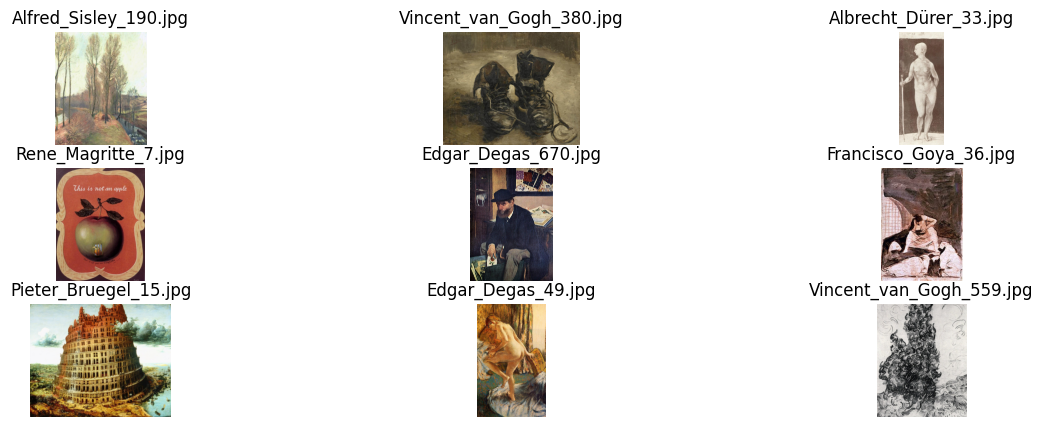

In [43]:
from tensorflow.keras.utils import load_img, img_to_array
fig,axe=plt.subplots(3,3,figsize=(15,5))

for i in range(3):
    for j in range(3):
        filename = rd.choice(total_df['filename'])
        img = load_img("data/" + filename)

          # Sélectionne une image appartenant à la classe k
        
        # Affiche l'image sur l'axe correspondant
        axe[i, j].imshow(img)  # Ajuster cmap selon vos images (ex: 'gray' pour images en niveaux de gris)
        axe[i, j].set_title(filename)  # Ajoute un titre pour chaque sous-graphe
        axe[i, j].axis('off')
    

In [34]:

sorted_data = total_df.iloc[:, 1].value_counts(ascending=False)
sorted_data

category
VincentvanGogh             877
EdgarDegas                 702
PabloPicasso               439
Pierre-AugusteRenoir       336
AlbrechtDürer              328
PaulGauguin                311
FranciscoGoya              291
Rembrandt                  262
AlfredSisley               259
Titian                     255
MarcChagall                239
ReneMagritte               194
AmedeoModigliani           193
PaulKlee                   188
HenriMatisse               186
AndyWarhol                 181
MikhailVrubel              171
SandroBotticelli           164
LeonardodaVinci            143
PeterPaulRubens            141
SalvadorDali               139
HieronymusBosch            137
PieterBruegel              134
DiegoVelazquez             128
KazimirMalevich            126
FridaKahlo                 120
GiottodiBondone            119
GustavKlimt                117
Raphael                    109
JoanMiro                   102
AndreiRublev                99
CamillePissarro             91

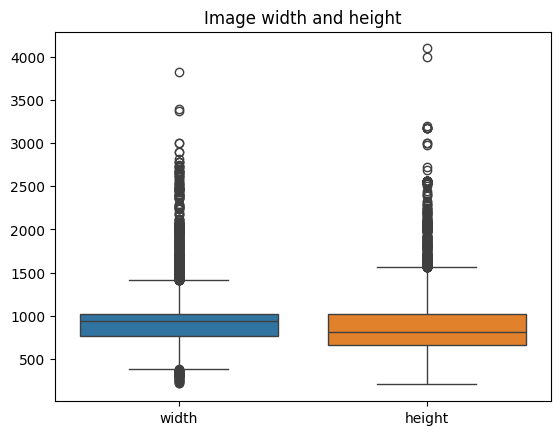

In [44]:
img_size = np.zeros((total_df.shape[0],2))
for i, filename in enumerate(total_df['filename']) :
    img = img_to_array( load_img("data/" + filename) )
    img_size[i,:] = img.shape[:2]

# --- #

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()

## Pretraitement

In [64]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(total_df, test_size=0.2, random_state=42)  # 80% train, 20% test
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 75% train, 25% val



In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 20  # d
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)


Found 5067 validated image filenames belonging to 50 classes.
Found 1689 validated image filenames belonging to 50 classes.
Found 1690 validated image filenames belonging to 50 classes.


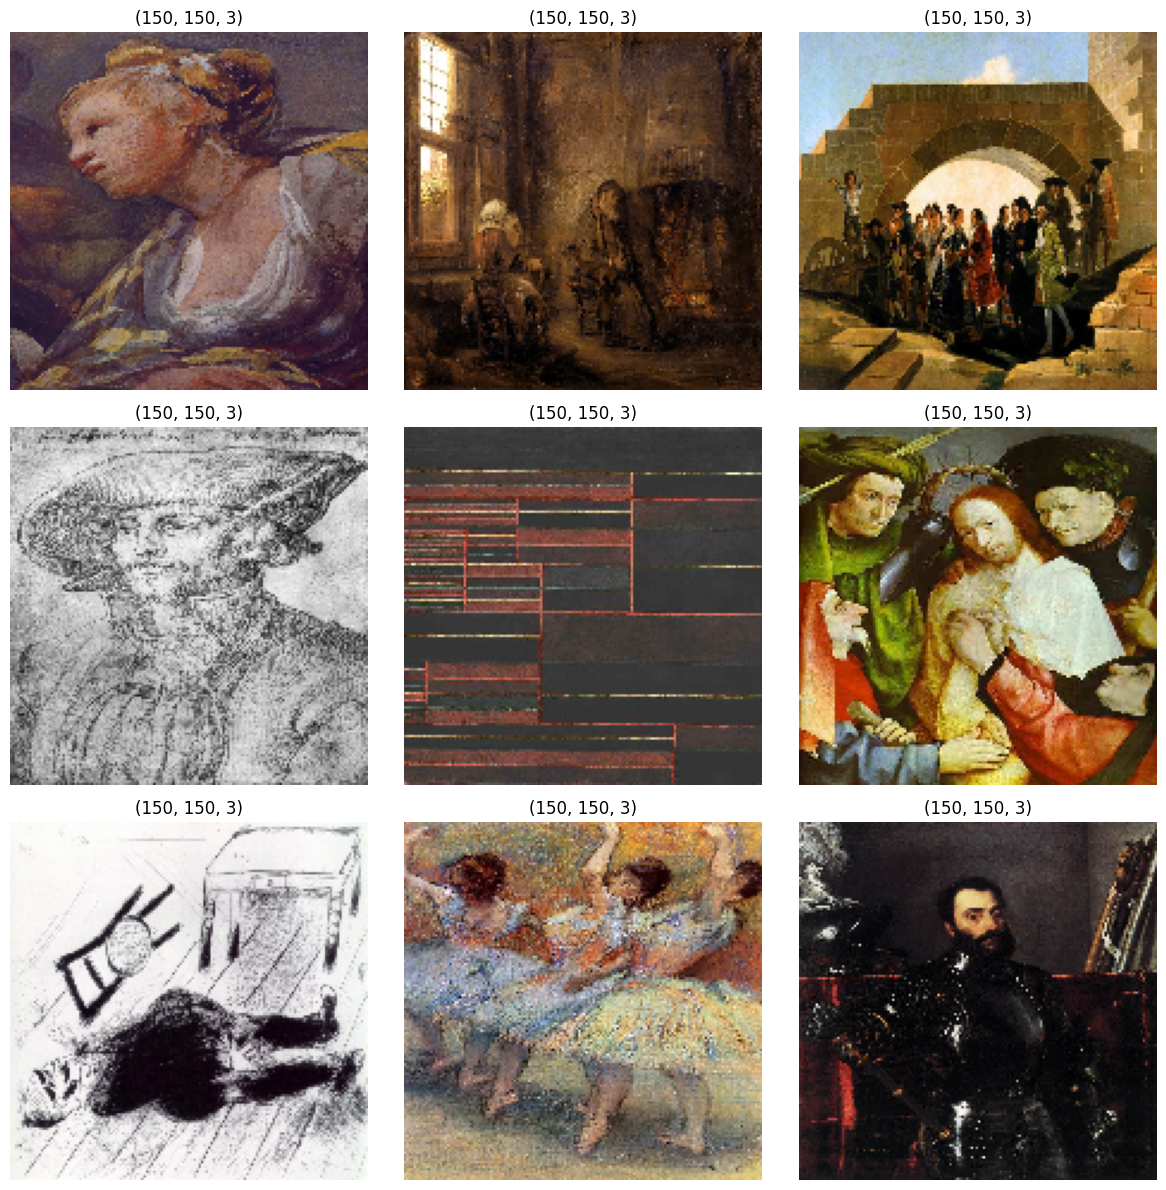

In [69]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in total_generator:
        img = x_batch[0]
        
        plt.title(str(img.shape))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break

plt.tight_layout()
plt.show()

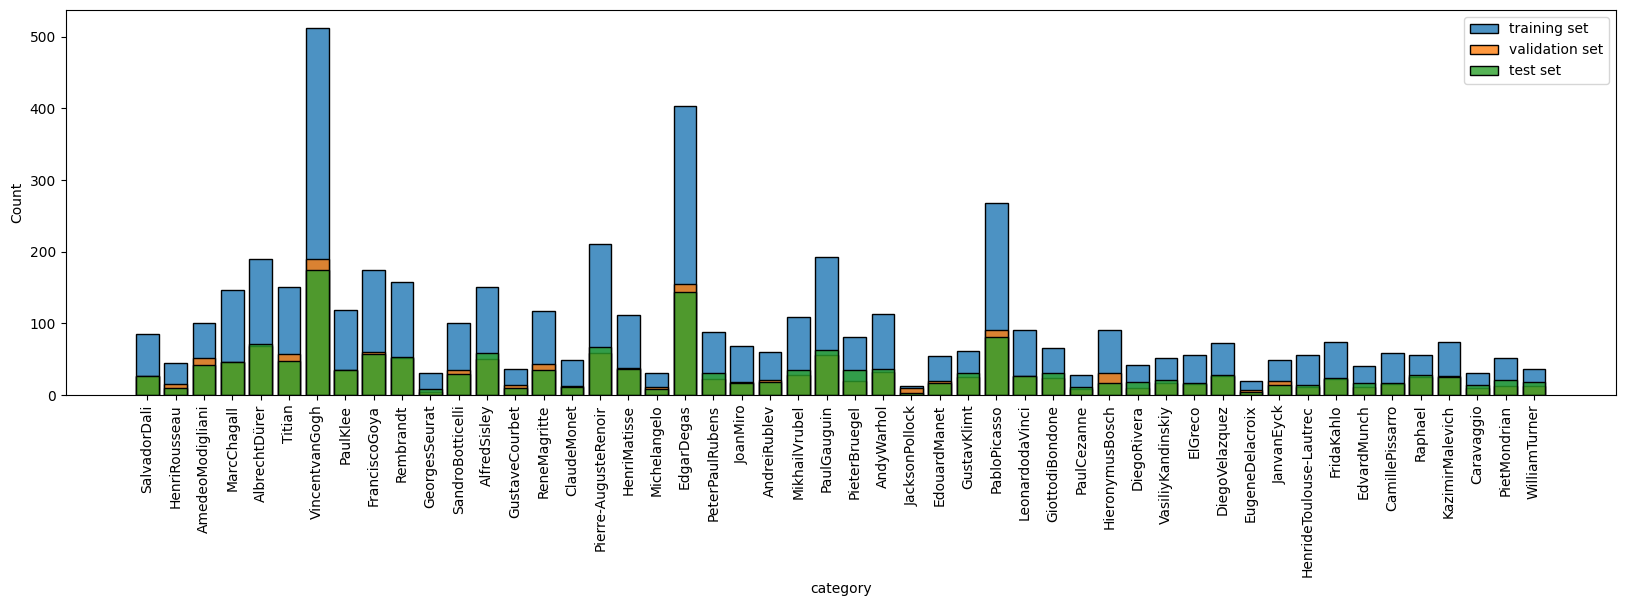

In [68]:
plt.figure(figsize=(20,5))

sns.histplot(train_df.iloc[:,1],label="training set",discrete=True, alpha=.8, shrink=.8)
sns.histplot(val_df.iloc[:,1],label="validation set",discrete=True, alpha=.8, shrink=.8)
sns.histplot(test_df.iloc[:,1],label="test set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)



plt.xticks(rotation=90)

plt.legend()

## First approach: Basic convolutional network

In [75]:
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(150,150, 3)))
cnn_simple.add(Conv2D(32, kernel_size=(3, 3), activation='relu', data_format="channels_last"))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Flatten())    # Vectorization of the tensor to connect it to a dense layer
cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(50, activation='softmax'))

cnn_simple.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,226 (2.25 MB)

 Trainable params: 590,226 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
cnn_simple.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

In [77]:
epochs = 10

t_learning_cnn_simple = time.time()
cnn_simple_history = cnn_simple.fit(
    train_generator,
    validation_data = val_generator,
    epochs = epochs
)
t_learning_cnn_simple = time.time() - t_learning_cnn_simple

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn_simple))

Epoch 1/10


/home/gadj/.conda/envs/tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


254/254 ━━━━━━━━━━━━━━━━━━━━ 101s 384ms/step - accuracy: 0.0688 - loss: 3.8519 - val_accuracy: 0.0900 - val_loss: 3.6538
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 87s 341ms/step - accuracy: 0.0815 - loss: 3.7261 - val_accuracy: 0.1314 - val_loss: 3.5549
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 81s 316ms/step - accuracy: 0.1125 - loss: 3.5897 - val_accuracy: 0.2001 - val_loss: 3.3963
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 76s 295ms/step - accuracy: 0.1440 - loss: 3.4650 - val_accuracy: 0.2256 - val_loss: 3.1915
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 75s 293ms/step - accuracy: 0.1721 - loss: 3.3438 - val_accuracy: 0.2315 - val_loss: 3.1237
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 75s 292ms/step - accuracy: 0.1908 - loss: 3.2497 - val_accuracy: 0.2339 - val_loss: 3.0166
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 75s 293ms/step - accuracy: 0.2000 - loss: 3.1430 - val_accuracy: 0.2854 - val_loss: 2.9354
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 75s 293ms/step - accuracy: 0.2277 - loss: 3.0399 - va

In [79]:
t_prediction_cnn_simple = time.time()

score_cnn_train = cnn_simple.evaluate(train_generator, verbose=1)
score_cnn_validation = cnn_simple.evaluate(val_generator, verbose=1)

t_prediction_cnn_simple = time.time() - t_prediction_cnn_simple

print('Train accuracy:', score_cnn_train[1])
print('Validation accuracy:', score_cnn_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_cnn_simple )

254/254 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.3154 - loss: 2.6410
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.2949 - loss: 2.8211
Train accuracy: 0.3189263939857483
Validation accuracy: 0.28833630681037903
Time Prediction: 42.85 seconds


In [84]:
total_df.head()
#for categorie in list_de_categories
#      demander au modèle de choisir le peintre
#      calculer l'accuracy et la sauvegarder
#histogramme des accuracy par peintre 
y=total_df[total_df["category"]=="AlbrechtDürer"]["filename"]

In [85]:
y

0        Albrecht_Dürer_1.jpg
1       Albrecht_Dürer_10.jpg
2      Albrecht_Dürer_100.jpg
3      Albrecht_Dürer_101.jpg
4      Albrecht_Dürer_102.jpg
                ...          
323     Albrecht_Dürer_87.jpg
324     Albrecht_Dürer_88.jpg
325     Albrecht_Dürer_89.jpg
326      Albrecht_Dürer_9.jpg
327     Albrecht_Dürer_90.jpg
Name: filename, Length: 328, dtype: object